# Neural Networks

### Fill out the parts with XXX's

## Python Imports

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

%matplotlib inline  

## Data Imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [41]:
data_dir = "/Users/mathildedue/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/master_bioinformatics/1.semester/22125_algorithms_in_bioinformatics/algorithms/data/"

### Define run time parameters

In [42]:
# Define if we are using blosum or sparse encoding
#blosum_scheme = False
blosum_scheme = True

### Alphabet

In [43]:
alphabet_file = data_dir + "Matrices/alphabet"
#alphabet_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_3/alphabet"

alphabet = np.loadtxt(alphabet_file, dtype=str)

### Blosum50 Encoding Scheme

In [44]:
blosum_file = data_dir + "Matrices/blosum50"
#blosum_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_3/blosum50"

_blosum50 = np.loadtxt(blosum_file, dtype=float).reshape((24, -1)).T

blosum50 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum50[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum50[letter_1][letter_2] = _blosum50[i, j] / 5.0

### Sparse Encoding Scheme

In [45]:
sparse_file = data_dir + "Matrices/sparse"
_sparse = np.loadtxt(sparse_file, dtype=float)
sparse = {}

for i, letter_1 in enumerate(alphabet):

    sparse[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):

        sparse[letter_1][letter_2] = _sparse[i, j]

## Peptide Encoding

In [46]:
def encode(peptides, encoding_scheme, alphabet):
    
    encoded_peptides = []

    for peptide in peptides:

        encoded_peptide = []

        for peptide_letter in peptide:

            for alphabet_letter in alphabet:

                encoded_peptide.append(encoding_scheme[peptide_letter][alphabet_letter])
        
        # add a 1 (bias)
        encoded_peptide.append(1)
        
        # store peptide
        encoded_peptides.append(encoded_peptide)
        
    return np.array(encoded_peptides)

## Neural Network Functions

### Error (RMS)

In [47]:
def error(y, y_pred):
    return 0.5*(y_pred - y)**2

### Activation (Sigmoid)

In [48]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

### Derivative of Activation

In [49]:
def sigmoid_prime(a):
    return (1-a)*a

### Forward Propagation

In [50]:
def forward(X, w1, w2):
   
    # get dimension, substracting the bias
    input_layer_dim = w1.shape[0] - 1 
    hidden_layer_dim = w2.shape[0] - 1
    
    ################
    # hidden layer #
    ################
    
    # activity of hidden layer
    for j in range(hidden_layer_dim):
        z = 0.0
        for i in range(input_layer_dim+1):
            z += X[0][i]* w1[i,j]
        X[1][j] = sigmoid(z)
    
    ################
    # output layer #
    ################
    
    z = 0
    for i in range(hidden_layer_dim+1):
        z += X[1][i]*w2[i,0]
    X[2][0] = sigmoid(z)

### Back Propagation (Gradient Descent)

In [51]:
def back_prop(X, t, w_h, w_o, dj_dw_h, dj_dw_o):
    
    # dj_dw_h are the derivativs with respect to the weights
    # connecting the input to the hidden layer
    # dj_dw_o are the derivatics with respect to the weights
    # connecting the hidden to the outout layer

    # get dimension, substracting the bias
    input_layer_dim = w_h.shape[0] - 1 
    hidden_layer_dim = w_o.shape[0] - 1
    
    ##############################################    
    # derivative of cost function respect to w_o #
    # Remember X[2][0] is the prediction value,
    # And dj_dw_o = dE/dw = dE/dO * dO/do * do/dw
    ##############################################
    
    delta = (X[2][0] - t) * sigmoid_prime(X[2][0])
    
    for i in range(hidden_layer_dim+1):
        
        dj_dw_o[i] = delta * X[1][i]  # X[1][i] is the output from the hidden layer
    
    ##############################################
    # derivative of cost function respect to w_h #
    # Remember dj_dw_h = dE/dv where v are the weight connecting
    # the input to the hidden layer, and
    # dE/dv = dE/dO * dO/do * do/dH * dH/dh * dh/dv
    # where H is the output from hidden neuron j, and v is the
    # weight connecting input neuron i to hidden neuron j
    ##############################################
    
    for j in range(hidden_layer_dim):

        delta2 = delta * w_o[j, 0] * sigmoid_prime(X[1][j])  
        
        for i in range (input_layer_dim+1): # +1 to include the input layer bias

            dj_dw_h[i, j] = delta2 * X[0][i]


### Save network to file

In [52]:
def save_network(file_name, w_h, w_o, lpcc, lerr, tpcc, terr, epochs):
    
    input_layer_dim = w_h.shape[0]
    hidden_layer_dim = w_o.shape[0]
    output_layer_dim = w_o.shape[1]

    with open(file_name, 'w') as file:

        
        # run data
        file.write("TESTRUNID")
        file.write(" EPOCH: " + str(epochs))
        file.write(" L_PCC: " + str(lpcc))
        file.write(" L_ERR: " + str(lerr))
        file.write(" T_PCC: " + str(tpcc))
        file.write(" T_ERR: " + str(terr))
        file.write("\n")

        # LAYER: 1 
        file.write(str(input_layer_dim-1) + " LAYER: 1")
        file.write("\n")

        # LAYER: 2 
        file.write(str(hidden_layer_dim-1) + " LAYER: 2")
        file.write("\n")

        # LAYER: 3
        file.write(str(output_layer_dim) + " LAYER: 3")
        file.write("\n")

        # number of training cycles
        # :ILEARN 
        file.write(str(epochs) + " :ILEARN")
        file.write("\n")
        
        # network weights (five per line)
        weights = [w_h, w_o]
        
        cnt = 0

        for w in weights:

            w = w.flatten()

            for i in range(0, len(w)):

                file.write(str(w[i]) + str("\t"))
                
                cnt += 1
                
                if cnt == 5:
                    file.write("\n")
                    cnt = 0
                    
        if cnt != 0:
            file.write("\n")
            
            

## Network Architecture (Feed Forward)

In [53]:
def feed_forward_network(input_layer_dim, hidden_layer_dim, output_layer_dim):
    
    # layer dimensions
    i_dim = input_layer_dim      # vector of shape (i_dim,) 
    h_dim = hidden_layer_dim     # matrix of shape (i_dim, h_dim)
    o_dim = output_layer_dim     # matrix of shape (h_dim, o_dim)
    
    # hidden layer weights
    # w_h[i, j] is the weight that links input's feature "i" to neuron "j" of the hidden layer
    w_h = np.random.uniform(-0.1, 0.1, size=(i_dim+1)*h_dim).reshape(i_dim+1, h_dim)
        
    # output layer weights
    # w_o[i, j] is the weight that links hidden layer's neuron "i" to neuron "j" of the output layer
    # since we only have one output neuron, j = 1, and w_o behaves as a vector, not a matrix
    w_o = np.random.uniform(-0.1, 0.1, size=(h_dim+1)*o_dim).reshape(h_dim+1, o_dim)
    
    # X matrix, X stores the output from each layer
    X_dim = max(i_dim, h_dim, o_dim)
    X = np.zeros(shape=(3, X_dim+1))
    
    # The last column of the X layer is one, to deal with the bias
    X[0][input_layer_dim] = 1.0 
    X[1][hidden_layer_dim] = 1.0
    
    # print network summary
    print("NETWORK SUMMARY")
    print("---------------" )
    print("Input Layer shape:", (1, input_layer_dim))
    print("Hidden Layer shape:", w_h.shape)
    print("Output layer shape:", w_o.shape)
    print("Total parameters:", (i_dim+1)*h_dim + (h_dim+1)*o_dim)
    print("")
    
    # return everything
    return w_h, w_o, X

## Training Data

In [54]:
training_file = data_dir + "ANN/A2403_training"
#training_file = data_dir + "ANN/A0201_training"
training_data = np.loadtxt(training_file, dtype=str)

peptides = training_data[:, 0]

if blosum_scheme:
    x_train = encode(peptides, blosum50, alphabet)
else:
    x_train = encode(peptides, sparse, alphabet)

y_train = np.array(training_data[:, 1], dtype=float)

## Evaluation Data

In [55]:
evaluation_file = data_dir + "ANN/A2403_evaluation"
#evaluation_file = data_dir + "ANN/A0201_evaluation"
evaluation_data = np.loadtxt(evaluation_file, dtype=str)

peptides = evaluation_data[:, 0]
if blosum_scheme:
    x_eval = encode(peptides, blosum50, alphabet)
else:
    x_eval = encode(peptides, sparse, alphabet)

y_eval = np.array(evaluation_data[:, 1], dtype=float)

## Train Network

In [56]:
# seed for this run
np.random.seed(1)

# create network
input_layer_dim = 180
hidden_layer_dim = 5
output_layer_dim = 1

w_h, w_o, X = feed_forward_network(input_layer_dim, hidden_layer_dim, output_layer_dim)

# create backpropagation matrices
dj_dw_h = np.zeros(shape=w_h.shape)
dj_dw_o = np.zeros(shape=w_o.shape)


# training epochs
epochs = 100

# learning rate
epsilon = 0.05

# data for plotting
train_error = []
train_perf = []
eval_error = []
eval_perf = []

# early stopping
early_stopping = True
best_error = np.inf

# define filename for synaps
synfile_name = "my_A2403_sp.syn"

#############
# MAIN LOOP #
#############

# for each epoch
for e in range(0, epochs):
    
    ############
    # TRAINING #
    ############
    
    train_error_acum = 0
    y_preds_train = []
    
    # shuffle input
    randomize = np.arange(len(x_train))
    np.random.shuffle(randomize)
    x_train, y_train = x_train[randomize], y_train[randomize]
    
    # loop
    for i in range(0, len(x_train)):        
        
        # fetch training point
        #x = x_train[i]
        X[0] = x_train[i]
        y = y_train[i]
        
        # forward propagation
        #X = forward(X, w_h, w_o)
        forward(X, w_h, w_o)
        y_pred = X[2][0]
        y_preds_train.append(y_pred)
        
        # back propagation
        # dj_dw_h = dE/dv, v is weight between input and hidden layer
        # dj_dw_o = dE/dw, wis weight between hidden and output layer
        back_prop(X, y, w_h, w_o, dj_dw_h, dj_dw_o)
        
        # update weights & biases
        w_h -= epsilon * dj_dw_h
        w_o -= epsilon * dj_dw_o
    
        # store training error
        train_error_acum += error(y, y_pred)

    # store training performance
    train_pcc = pearsonr(y_train, np.asarray(y_preds_train))[0]
    train_perf.append(train_pcc)

    # store mean training error
    mean_train_error = train_error_acum/len(x_train)
    train_error.append(mean_train_error)

    ##############
    # EVALUATION #
    ##############
    
    eval_error_acum = 0
    y_preds_eval = []
    
    # loop
    for i in range(0, len(x_eval)):        
        
        # fetch training point
        x = x_eval[i]
        y = y_eval[i]
        
        X[0] = x
        
        # forward propagation
        forward(X, w_h, w_o)
        y_pred = X[2][0]
        y_preds_eval.append(y_pred)
        
        # store evaluation error
        eval_error_acum += error(y, y_pred)
    
    # store training performance
    eval_pcc = pearsonr(y_eval, np.asarray(y_preds_eval))[0]
    eval_perf.append(eval_pcc)
    
    # store mean evaluation error
    mean_eval_error = eval_error_acum/len(x_eval)
    eval_error.append(mean_eval_error)
    
    # early stopping
    if early_stopping:
        
        if mean_eval_error < best_error:
            
            best_error = mean_eval_error
            best_pcc = eval_pcc
            
            print("# Dump network", e, "Best MSE", best_error, "PCC", eval_pcc)
            
            save_network(synfile_name, w_h, w_o, train_pcc, mean_train_error, best_pcc, best_error, e)         
            
    
    # print
    print([e,epochs], \
          "Train Error:", round(mean_train_error, 4), "|", \
          "Train Perf:", round(train_pcc, 4), "|", \
          "Eval Error:", round(mean_eval_error, 4), "|", \
          "Eval Perf:", round(eval_pcc, 4))
         

NETWORK SUMMARY
---------------
Input Layer shape: (1, 180)
Hidden Layer shape: (181, 5)
Output layer shape: (6, 1)
Total parameters: 911

# Dump network 0 Best MSE 0.029074627692062864 PCC 0.06594255621964225
[0, 100] Train Error: 0.0434 | Train Perf: -0.0497 | Eval Error: 0.0291 | Eval Perf: 0.0659
# Dump network 1 Best MSE 0.02560241179982887 PCC 0.1677747371869446
[1, 100] Train Error: 0.0294 | Train Perf: -0.0325 | Eval Error: 0.0256 | Eval Perf: 0.1678
# Dump network 2 Best MSE 0.02462632242451615 PCC 0.24209735503047766
[2, 100] Train Error: 0.0275 | Train Perf: 0.2377 | Eval Error: 0.0246 | Eval Perf: 0.2421
# Dump network 3 Best MSE 0.024314729018992044 PCC 0.2934120478599686
[3, 100] Train Error: 0.0269 | Train Perf: 0.3604 | Eval Error: 0.0243 | Eval Perf: 0.2934
# Dump network 4 Best MSE 0.024067245095579604 PCC 0.3294988342823889
[4, 100] Train Error: 0.0264 | Train Perf: 0.4398 | Eval Error: 0.0241 | Eval Perf: 0.3295
# Dump network 5 Best MSE 0.023858827045667982 PCC 0.3

### Performance Report

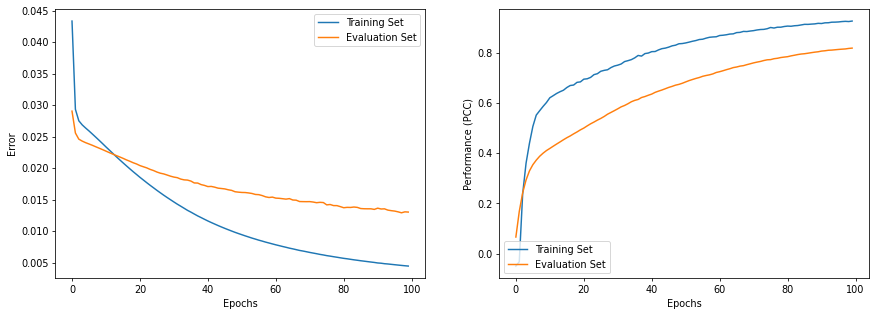

In [57]:
fig = plt.figure(figsize=(15, 5), dpi = 70)

x = np.arange(0, epochs)

# error subplot
plt.subplot(1, 2, 1)
plt.plot(x, train_error, label="Training Set")
plt.plot(x, eval_error, label="Evaluation Set")
plt.ylabel("Error", fontsize=10);
plt.xlabel("Epochs", fontsize=10);
plt.legend(loc='upper right');

# performance subplot
plt.subplot(1, 2, 2)
plt.plot(x, train_perf, label="Training Set")
plt.plot(x, eval_perf, label="Evaluation Set")
plt.ylabel("Performance (PCC)", fontsize=10);
plt.xlabel("Epochs", fontsize=10);
plt.legend(loc='lower left');

What is the training and evaluation performances of the network (in terms of the Pearson's correlation)? Do the same thing using blosum encoding. Are there any striking differences in the course of the training for the two encoding schemes? Can you understand this difference?
- The PCC score is higher with the BLOSUM encoding. This could be because of the more 